In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow
import tensorflow as tf
print(tf.__version__)

import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU



from time import time
import numpy as np

from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

2.9.3


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,validation_split = 0.2)
train_data=train.flow_from_directory(directory = 'DATASET/TRAIN',target_size=(224,224),
                                     batch_size=32,class_mode='categorical')

Found 2003 images belonging to 4 classes.


In [4]:
test=ImageDataGenerator(rescale=1./255)
test_data=test.flow_from_directory(directory = 'DATASET/TEST',target_size=(224,224),
                                   batch_size=32,class_mode='categorical')

Found 2003 images belonging to 4 classes.


In [ ]:
def shufflenet(input_shape, n_classes, g=8):
  channels = 384, 769, 1536
  repetitions = 3, 7, 3
  
  def ch_shuffle(x, g):
#     1 2 3 4 5 6 7 8 9 -reshape-> 1 2 3 -permute dims-> 1 4 7 -reshape-> 1 4 7 2 5 8 3 6 9
#                                  4 5 6                 2 5 8
#                                  7 8 9                 3 6 9
    
    _, w, h, ch = K.int_shape(x)
    ch_g = ch // g
    
    def shuffle_op(x):
      x = K.reshape(x, [-1, w, h, ch_g, g])
      x = K.permute_dimensions(x, [0, 1, 2, 4, 3])
      x = K.reshape(x, [-1, w, h, ch])
      return x
    
    x = Lambda(shuffle_op)(x)
    return x
    
  
  def gconv(tensor, ch, g):
    _, _, _, in_ch = K.int_shape(tensor)
    ch_g = in_ch // g
    out_ch = ch // g
    group = []
    
    for i in range(g):
#       x = tensor[:, :, :, i*ch_g:(i+1)*ch_g]
      x = Lambda(lambda x: x[:, :, :, i*ch_g: (i+1)*ch_g])(tensor)
      x = Conv2D(out_ch, 1)(x)
      group.append(x)
    
    x = Concatenate()(group)
    return x
  
  
  def shufflenet_block(tensor, ch, s, g):
    x = gconv(tensor, ch // 4, g)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = ch_shuffle(x, g)
    x = DepthwiseConv2D(3, strides=s, padding='same')(x)
    x = BatchNormalization()(x)
    x = gconv(x, ch if s==1 else ch-K.int_shape(tensor)[-1], g)
    x = BatchNormalization()(x)
    
    if s == 1:
      x = Add()([tensor, x])
    else:
      avg = AvgPool2D(3, strides=2, padding='same')(tensor)
      x = Concatenate()([avg, x])
    
    output = ReLU()(x)
    return output
  
  
  def stage(x, ch, r, g):
    x = shufflenet_block(x, ch, 2, g)
    
    for i in range(r):
      x = shufflenet_block(x, ch, 1, g)
      
    return x
  
  input = Input(input_shape)
  
  x = Conv2D(24, 3, strides=2, padding='same')(input)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  for ch, r in zip(channels, repetitions):
    x = stage(x, ch, r, g)
    
  x = GlobalAvgPool2D()(x)
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy',tensorflow.keras.metrics.Precision()])
  return model
     

input_shape = 224, 224, 3
n_classes = 4

K.clear_session()
model = shufflenet(input_shape, n_classes)
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 24  672         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 24  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 lambda_53 (Lambda)             (None, 28, 28, 48)   0           ['re_lu_6[0][0]']                
                                                                                                  
 lambda_54 (Lambda)             (None, 28, 28, 48)   0           ['re_lu_6[0][0]']                
                                                                                                  
 lambda_55 (Lambda)             (None, 28, 28, 48)   0           ['re_lu_6[0][0]']                
                                                                                                  
 lambda_56 (Lambda)             (None, 28, 28, 48)   0           ['re_lu_6[0][0]']                
                                                                                                  
 lambda_57 (Lambda)             (None, 28, 28, 48)   0           ['re_lu_6[0][0]']                
          

 concatenate_8 (Concatenate)    (None, 28, 28, 384)  0           ['conv2d_57[0][0]',              
                                                                  'conv2d_58[0][0]',              
                                                                  'conv2d_59[0][0]',              
                                                                  'conv2d_60[0][0]',              
                                                                  'conv2d_61[0][0]',              
                                                                  'conv2d_62[0][0]',              
                                                                  'conv2d_63[0][0]',              
                                                                  'conv2d_64[0][0]']              
                                                                                                  
 batch_normalization_12 (BatchN  (None, 28, 28, 384)  1536       ['concatenate_8[0][0]']          
 ormalizat

 lambda_83 (Lambda)             (None, 14, 14, 24)   0           ['batch_normalization_14[0][0]'] 
                                                                                                  
 lambda_84 (Lambda)             (None, 14, 14, 24)   0           ['batch_normalization_14[0][0]'] 
                                                                                                  
 conv2d_73 (Conv2D)             (None, 14, 14, 48)   1200        ['lambda_77[0][0]']              
                                                                                                  
 conv2d_74 (Conv2D)             (None, 14, 14, 48)   1200        ['lambda_78[0][0]']              
                                                                                                  
 conv2d_75 (Conv2D)             (None, 14, 14, 48)   1200        ['lambda_79[0][0]']              
                                                                                                  
 conv2d_76

                                                                                                  
 re_lu_11 (ReLU)                (None, 14, 14, 192)  0           ['batch_normalization_16[0][0]'] 
                                                                                                  
 lambda_93 (Lambda)             (None, 14, 14, 192)  0           ['re_lu_11[0][0]']               
                                                                                                  
 depthwise_conv2d_5 (DepthwiseC  (None, 14, 14, 192)  1920       ['lambda_93[0][0]']              
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_17 (BatchN  (None, 14, 14, 192)  768        ['depthwise_conv2d_5[0][0]']     
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_101 (Conv2D)            (None, 14, 14, 24)   2328        ['lambda_106[0][0]']             
                                                                                                  
 conv2d_102 (Conv2D)            (None, 14, 14, 24)   2328        ['lambda_107[0][0]']             
                                                                                                  
 conv2d_103 (Conv2D)            (None, 14, 14, 24)   2328        ['lambda_108[0][0]']             
                                                                                                  
 conv2d_104 (Conv2D)            (None, 14, 14, 24)   2328        ['lambda_109[0][0]']             
                                                                                                  
 concatenate_14 (Concatenate)   (None, 14, 14, 192)  0           ['conv2d_97[0][0]',              
          

                                                                                                  
 lambda_121 (Lambda)            (None, 14, 14, 96)   0           ['re_lu_14[0][0]']               
                                                                                                  
 lambda_122 (Lambda)            (None, 14, 14, 96)   0           ['re_lu_14[0][0]']               
                                                                                                  
 lambda_123 (Lambda)            (None, 14, 14, 96)   0           ['re_lu_14[0][0]']               
                                                                                                  
 lambda_124 (Lambda)            (None, 14, 14, 96)   0           ['re_lu_14[0][0]']               
                                                                                                  
 lambda_125 (Lambda)            (None, 14, 14, 96)   0           ['re_lu_14[0][0]']               
          

 concatenate_17 (Concatenate)   (None, 14, 14, 768)  0           ['conv2d_121[0][0]',             
                                                                  'conv2d_122[0][0]',             
                                                                  'conv2d_123[0][0]',             
                                                                  'conv2d_124[0][0]',             
                                                                  'conv2d_125[0][0]',             
                                                                  'conv2d_126[0][0]',             
                                                                  'conv2d_127[0][0]',             
                                                                  'conv2d_128[0][0]']             
                                                                                                  
 batch_normalization_24 (BatchN  (None, 14, 14, 768)  3072       ['concatenate_17[0][0]']         
 ormalizat

 lambda_151 (Lambda)            (None, 14, 14, 24)   0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 lambda_152 (Lambda)            (None, 14, 14, 24)   0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 conv2d_137 (Conv2D)            (None, 14, 14, 96)   2400        ['lambda_145[0][0]']             
                                                                                                  
 conv2d_138 (Conv2D)            (None, 14, 14, 96)   2400        ['lambda_146[0][0]']             
                                                                                                  
 conv2d_139 (Conv2D)            (None, 14, 14, 96)   2400        ['lambda_147[0][0]']             
                                                                                                  
 conv2d_14

 lambda_161 (Lambda)            (None, 14, 14, 192)  0           ['re_lu_19[0][0]']               
                                                                                                  
 depthwise_conv2d_9 (DepthwiseC  (None, 14, 14, 192)  1920       ['lambda_161[0][0]']             
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_29 (BatchN  (None, 14, 14, 192)  768        ['depthwise_conv2d_9[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 lambda_162 (Lambda)            (None, 14, 14, 24)   0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 lambda_16

 conv2d_166 (Conv2D)            (None, 14, 14, 24)   2328        ['lambda_175[0][0]']             
                                                                                                  
 conv2d_167 (Conv2D)            (None, 14, 14, 24)   2328        ['lambda_176[0][0]']             
                                                                                                  
 conv2d_168 (Conv2D)            (None, 14, 14, 24)   2328        ['lambda_177[0][0]']             
                                                                                                  
 concatenate_22 (Concatenate)   (None, 14, 14, 192)  0           ['conv2d_161[0][0]',             
                                                                  'conv2d_162[0][0]',             
                                                                  'conv2d_163[0][0]',             
                                                                  'conv2d_164[0][0]',             
          

 lambda_190 (Lambda)            (None, 14, 14, 96)   0           ['re_lu_22[0][0]']               
                                                                                                  
 lambda_191 (Lambda)            (None, 14, 14, 96)   0           ['re_lu_22[0][0]']               
                                                                                                  
 lambda_192 (Lambda)            (None, 14, 14, 96)   0           ['re_lu_22[0][0]']               
                                                                                                  
 lambda_193 (Lambda)            (None, 14, 14, 96)   0           ['re_lu_22[0][0]']               
                                                                                                  
 lambda_194 (Lambda)            (None, 14, 14, 96)   0           ['re_lu_22[0][0]']               
                                                                                                  
 conv2d_17

                                                                  'conv2d_188[0][0]',             
                                                                  'conv2d_189[0][0]',             
                                                                  'conv2d_190[0][0]',             
                                                                  'conv2d_191[0][0]',             
                                                                  'conv2d_192[0][0]']             
                                                                                                  
 batch_normalization_36 (BatchN  (None, 14, 14, 768)  3072       ['concatenate_25[0][0]']         
 ormalization)                                                                                    
                                                                                                  
 add_9 (Add)                    (None, 14, 14, 768)  0           ['re_lu_22[0][0]',               
          

                                                                                                  
 conv2d_201 (Conv2D)            (None, 7, 7, 96)     4704        ['lambda_213[0][0]']             
                                                                                                  
 conv2d_202 (Conv2D)            (None, 7, 7, 96)     4704        ['lambda_214[0][0]']             
                                                                                                  
 conv2d_203 (Conv2D)            (None, 7, 7, 96)     4704        ['lambda_215[0][0]']             
                                                                                                  
 conv2d_204 (Conv2D)            (None, 7, 7, 96)     4704        ['lambda_216[0][0]']             
                                                                                                  
 conv2d_205 (Conv2D)            (None, 7, 7, 96)     4704        ['lambda_217[0][0]']             
          

 lambda_229 (Lambda)            (None, 7, 7, 384)    0           ['re_lu_27[0][0]']               
                                                                                                  
 depthwise_conv2d_13 (Depthwise  (None, 7, 7, 384)   3840        ['lambda_229[0][0]']             
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_41 (BatchN  (None, 7, 7, 384)   1536        ['depthwise_conv2d_13[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 lambda_230 (Lambda)            (None, 7, 7, 48)     0           ['batch_normalization_41[0][0]'] 
                                                                                                  
 lambda_23

 conv2d_230 (Conv2D)            (None, 7, 7, 48)     9264        ['lambda_243[0][0]']             
                                                                                                  
 conv2d_231 (Conv2D)            (None, 7, 7, 48)     9264        ['lambda_244[0][0]']             
                                                                                                  
 conv2d_232 (Conv2D)            (None, 7, 7, 48)     9264        ['lambda_245[0][0]']             
                                                                                                  
 concatenate_31 (Concatenate)   (None, 7, 7, 384)    0           ['conv2d_225[0][0]',             
                                                                  'conv2d_226[0][0]',             
                                                                  'conv2d_227[0][0]',             
                                                                  'conv2d_228[0][0]',             
          

 lambda_258 (Lambda)            (None, 7, 7, 192)    0           ['re_lu_30[0][0]']               
                                                                                                  
 lambda_259 (Lambda)            (None, 7, 7, 192)    0           ['re_lu_30[0][0]']               
                                                                                                  
 lambda_260 (Lambda)            (None, 7, 7, 192)    0           ['re_lu_30[0][0]']               
                                                                                                  
 lambda_261 (Lambda)            (None, 7, 7, 192)    0           ['re_lu_30[0][0]']               
                                                                                                  
 lambda_262 (Lambda)            (None, 7, 7, 192)    0           ['re_lu_30[0][0]']               
                                                                                                  
 conv2d_24

                                                                  'conv2d_252[0][0]',             
                                                                  'conv2d_253[0][0]',             
                                                                  'conv2d_254[0][0]',             
                                                                  'conv2d_255[0][0]',             
                                                                  'conv2d_256[0][0]']             
                                                                                                  
 batch_normalization_48 (BatchN  (None, 7, 7, 1536)  6144        ['concatenate_34[0][0]']         
 ormalization)                                                                                    
                                                                                                  
 add_12 (Add)                   (None, 7, 7, 1536)   0           ['re_lu_30[0][0]',               
          

In [ ]:
model_path = "SHUFFLE.h5"

from keras.callbacks import ModelCheckpoint

M = ModelCheckpoint(model_path, monitor='accuracy', verbose=1, save_best_only=True)

In [ ]:
epochs = 100
batch_size = 512

In [8]:
#### Fitting the model
history = model.fit(
           train_data, steps_per_epoch=train_data.samples // batch_size, 
           epochs=epochs, 
           validation_data=test_data,validation_steps=test_data.samples // batch_size,
           callbacks=[M])

3/3 [==============================] - ETA: 0s - loss: 2.6482 - accuracy: 0.2396 - precision: 0.2297 
Epoch 1: accuracy improved from -inf to 0.23958, saving model to SHUFFLE.h5
3/3 [==============================] - 249s 55s/step - loss: 2.6482 - accuracy: 0.2396 - precision: 0.2297 - val_loss: 1.3995 - val_accuracy: 0.2396 - val_precision: 0.0000e+00
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 2.5632 - accuracy: 0.2708 - precision: 0.2889 
Epoch 2: accuracy improved from 0.23958 to 0.27083, saving model to SHUFFLE.h5
3/3 [==============================] - 81s 30s/step - loss: 2.5632 - accuracy: 0.2708 - precision: 0.2889 - val_loss: 1.3853 - val_accuracy: 0.2812 - val_precision: 0.0000e+00
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 1.7090 - accuracy: 0.3646 - precision: 0.3611 
Epoch 3: accuracy improved from 0.27083 to 0.36458, saving model to SHUFFLE.h5
3/3 [==============================] - 80s 29s/step - loss: 1.7090 - accuracy: 0.36

15/15 [==============================] - ETA: 0s - loss: 0.3989 - accuracy: 0.8125 - precision: 0.8125
Epoch 72: accuracy did not improve from 0.87931
15/15 [==============================] - 74s 5s/step - loss: 0.3989 - accuracy: 0.8125 - precision: 0.8125 - val_loss: 0.7093 - val_accuracy: 0.7500 - val_precision: 0.7537
Epoch 73/100
15/15 [==============================] - ETA: 0s - loss: 0.3194 - accuracy: 0.8646 - precision: 0.8640
Epoch 73: accuracy did not improve from 0.87931
15/15 [==============================] - 77s 5s/step - loss: 0.3194 - accuracy: 0.8646 - precision: 0.8640 - val_loss: 0.4612 - val_accuracy: 0.8042 - val_precision: 0.8110
Epoch 74/100
15/15 [==============================] - ETA: 0s - loss: 0.3758 - accuracy: 0.8104 - precision: 0.8121
Epoch 74: accuracy did not improve from 0.87931
15/15 [==============================] - 77s 5s/step - loss: 0.3758 - accuracy: 0.8104 - precision: 0.8121 - val_loss: 2.5026 - val_accuracy: 0.4563 - val_precision: 0.4582
Ep

15/15 [==============================] - 85s 6s/step - loss: 0.3356 - accuracy: 0.8313 - precision: 0.8330 - val_loss: 2.1716 - val_accuracy: 0.5521 - val_precision: 0.5493
Epoch 97/100
15/15 [==============================] - ETA: 0s - loss: 0.3385 - accuracy: 0.8438 - precision: 0.8434
Epoch 97: accuracy did not improve from 0.87931
15/15 [==============================] - 88s 6s/step - loss: 0.3385 - accuracy: 0.8438 - precision: 0.8434 - val_loss: 0.3798 - val_accuracy: 0.8417 - val_precision: 0.8428
Epoch 98/100
15/15 [==============================] - ETA: 0s - loss: 0.2754 - accuracy: 0.8771 - precision: 0.8771
Epoch 98: accuracy did not improve from 0.87931
15/15 [==============================] - 80s 5s/step - loss: 0.2754 - accuracy: 0.8771 - precision: 0.8771 - val_loss: 1.6037 - val_accuracy: 0.7042 - val_precision: 0.7056
Epoch 99/100
15/15 [==============================] - ETA: 0s - loss: 0.2683 - accuracy: 0.8792 - precision: 0.8792
Epoch 99: accuracy did not improve fr

In [9]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'val_loss', 'val_accuracy', 'val_precision'])

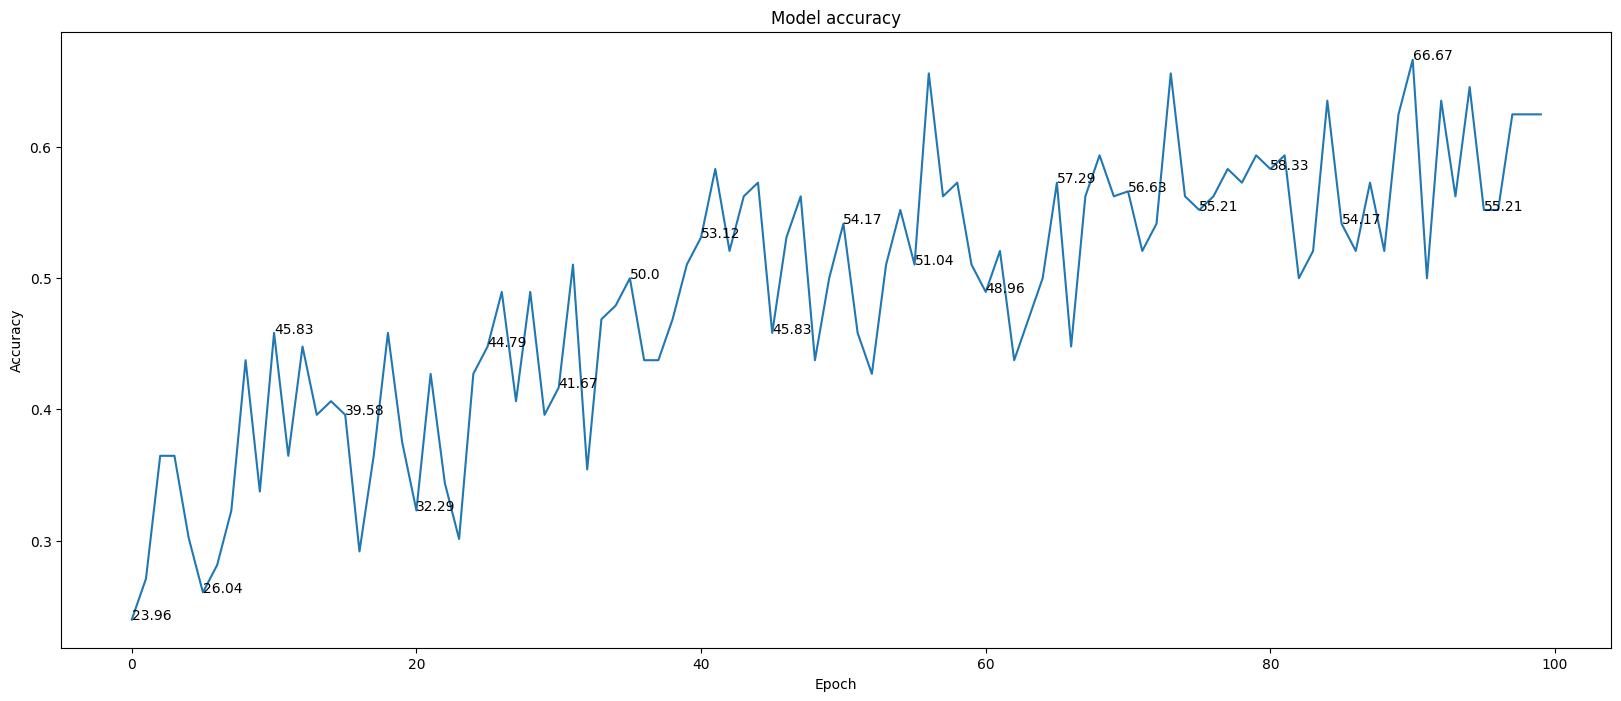

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['accuracy'][i]*100,2),xy=(i,history.history['accuracy'][i]))

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

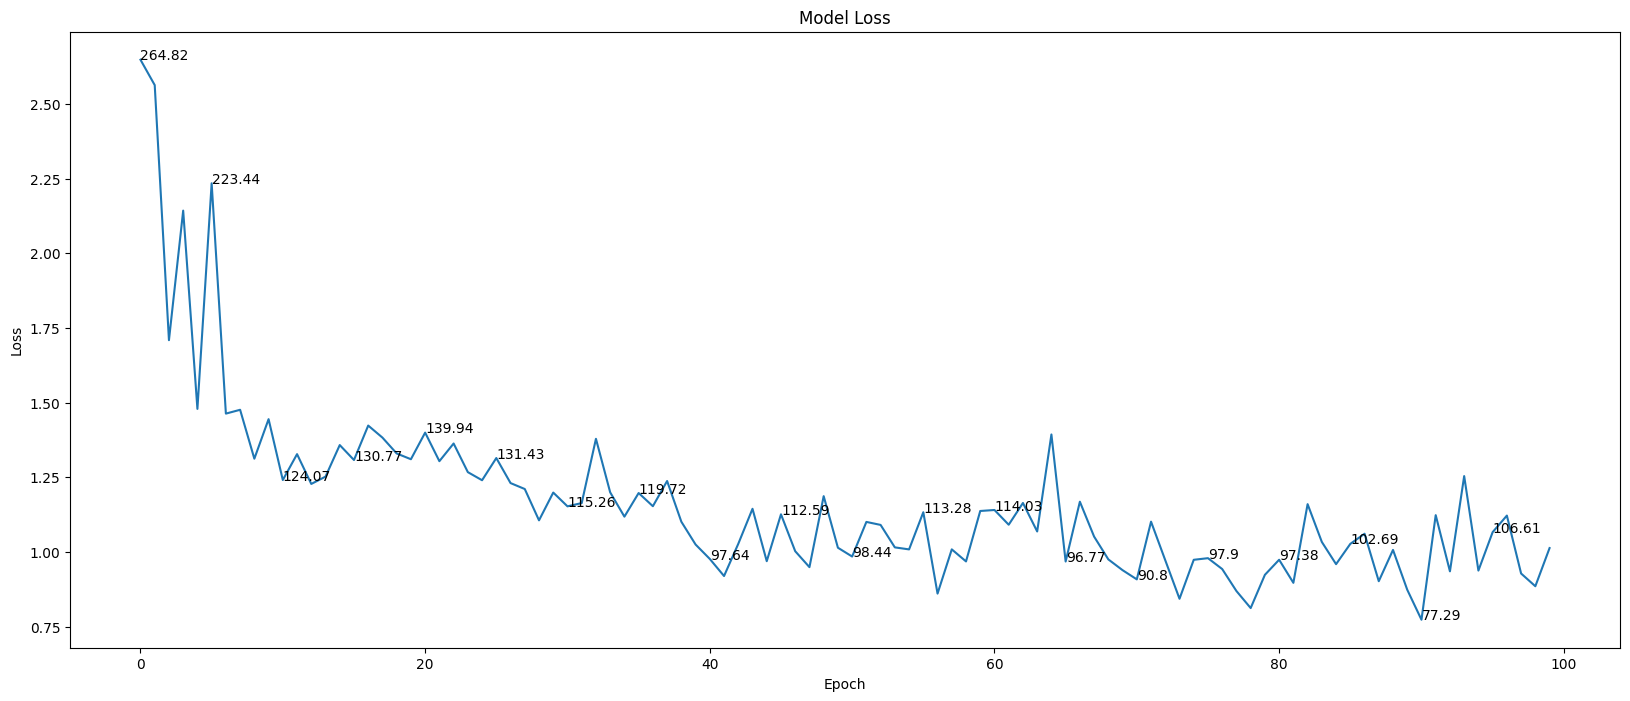

In [11]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['loss'][i]*100,2),xy=(i,history.history['loss'][i]))

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

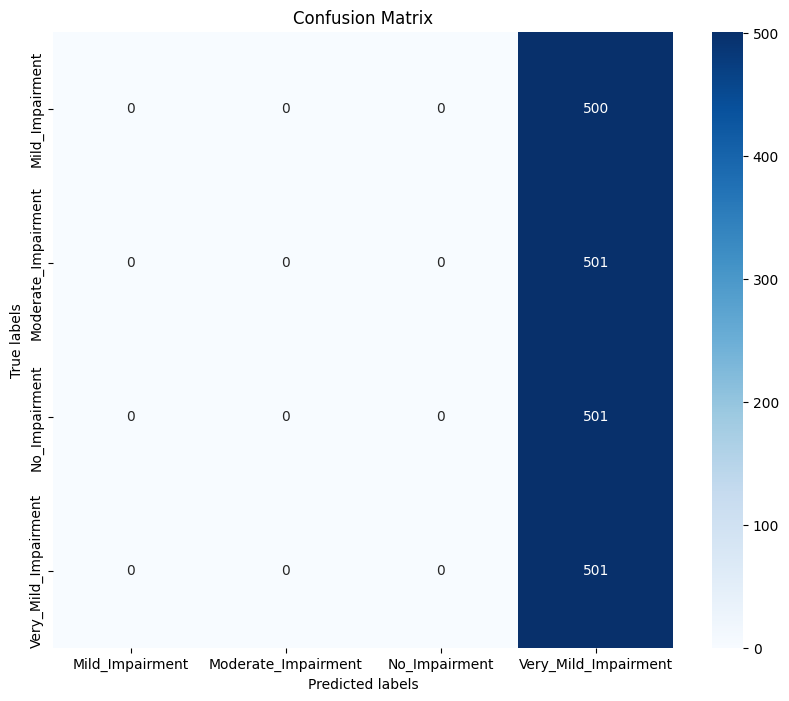

                      precision    recall  f1-score   support

     Mild_Impairment       0.00      0.00      0.00       500
 Moderate_Impairment       0.00      0.00      0.00       501
       No_Impairment       0.00      0.00      0.00       501
Very_Mild_Impairment       0.25      1.00      0.40       501

            accuracy                           0.25      2003
           macro avg       0.06      0.25      0.10      2003
        weighted avg       0.06      0.25      0.10      2003



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

test_steps = len(test_data)
num_classes = len(train_data.class_indices)

# Generate predictions
predictions = model.predict_generator(test_data, steps=test_steps)
y_pred = np.argmax(predictions, axis=1)

# Get true labels
true_labels = test_data.classes

conf_matrix = confusion_matrix(true_labels, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=train_data.class_indices.keys(), yticklabels=train_data.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_labels = [str(key) for key in train_data.class_indices.keys()]
print(classification_report(true_labels, y_pred, target_names=class_labels))